In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:
import cv2
import os
import torch
import random
import pickle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [ ]:
# задаем пути к разархивированным данным
data_path = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1'
train_dir = os.path.join(data_path, 'Train')
val_dir = os.path.join(data_path, 'Test')
meta_dir = os.path.join(data_path, 'Meta')
%ls /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Train

0/   11/  14/  17/  2/   22/  25/  28/  30/  33/  36/  39/  41/  6/  9/
1/   12/  15/  18/  20/  23/  26/  29/  31/  34/  37/  4/   42/  7/
10/  13/  16/  19/  21/  24/  27/  3/   32/  35/  38/  40/  5/   8/


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Путь к исходной папке с данными
source_dir = train_dir  # Папка с исходными данными, разбитыми по классам
output_dir = os.path.join(data_path, 'ProcessedData')  # Папка для хранения разделенных данных

# Создаем папки для тренировочных и тестовых данных
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Разделение данных
test_size = 0.2  # Доля данных для тестового набора

# Проходим по каждому классу
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    # Проверяем, что это директория
    if os.path.isdir(class_path):
        # Создаем соответствующие папки для класса в train и test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Получаем список всех файлов в классе
        files = os.listdir(class_path)
        files = [f for f in files if os.path.isfile(os.path.join(class_path, f))]

        # Разделяем файлы на тренировочные и тестовые
        train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

        # Копируем файлы в соответствующие папки
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_dir, class_name, file))
        for file in test_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(test_dir, class_name, file))

print(f"Данные успешно разделены. Тренировочные данные: {train_dir}, Тестовые данные: {test_dir}")


Данные успешно разделены. Тренировочные данные: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/ProcessedData/train, Тестовые данные: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/ProcessedData/test


In [ ]:
IMG_SIZE = (224, 224)  # ResNet50 ожидает 224x224 изображения
BATCH_SIZE = 32
NUM_CLASSES = 43  # GTSRB содержит 43 класса
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# 2. Загрузка предобученной ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 3. Добавление пользовательских слоев
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Дополнительный плотный слой
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 4. "Заморозка" базовой модели для предотвращения изменения весов во время начального обучения
for layer in base_model.layers:
    layer.trainable = False

# 5. Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 6. Обучение модели
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# 7. Разморозка и дообучение
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)
save_model(model, 'ResNet50.h5')

Found 25110 images belonging to 43 classes.
Found 1550 images belonging to 43 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


785/785 ━━━━━━━━━━━━━━━━━━━━ 340s 414ms/step - accuracy: 0.0767 - loss: 3.4676 - val_accuracy: 0.1439 - val_loss: 3.2432
Epoch 2/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 363s 397ms/step - accuracy: 0.1299 - loss: 3.2320 - val_accuracy: 0.1761 - val_loss: 3.0930
Epoch 3/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 328s 405ms/step - accuracy: 0.1818 - loss: 3.0201 - val_accuracy: 0.1445 - val_loss: 3.0081
Epoch 4/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 316s 398ms/step - accuracy: 0.2039 - loss: 2.8927 - val_accuracy: 0.1981 - val_loss: 2.9030
Epoch 5/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 317s 401ms/step - accuracy: 0.2280 - loss: 2.7980 - val_accuracy: 0.1903 - val_loss: 2.8806
Epoch 6/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 316s 399ms/step - accuracy: 0.2328 - loss: 2.7373 - val_accuracy: 0.2271 - val_loss: 2.7963
Epoch 7/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 315s 398ms/step - accuracy: 0.2534 - loss: 2.6587 - val_accuracy: 0.1826 - val_loss: 2.8512
Epoch 8/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 311s 393ms/step - accuracy: 0.2620 - loss: 2.59

In [ ]:
# Создание генераторов данных с аугментацией
train2_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.2
)

train2_generator = train2_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val2_generator = train2_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# 2. Загрузка предобученной модели VGG16
base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 3. Добавление пользовательских слоев
x = base_model2.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)  # Первый плотный слой
x = Dropout(0.5)(x)  # Dropout для регуляризации
x = Dense(256, activation='relu')(x)  # Второй плотный слой
x = Dropout(0.5)(x)  # Dropout для регуляризации
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # Выходной слой с количеством классов GTSRB

model2 = Model(inputs=base_model2.input, outputs=predictions)

# 4. Заморозка базовых слоев
for layer in base_model.layers:
    layer.trainable = False

# 5. Компиляция модели
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 6. Обучение модели
history = model2.fit(
    train2_generator,
    epochs=5,
    validation_data=val2_generator
)

# 7. Разморозка и дообучение
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    train2_generator,
    epochs=5,
    validation_data=val2_generator
)

# 8. Сохранение модели
model.save('vgg16.h5')

Found 25110 images belonging to 43 classes.
Found 1550 images belonging to 43 classes.
Epoch 1/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 467s 582ms/step - accuracy: 0.0491 - loss: 3.7180 - val_accuracy: 0.0581 - val_loss: 3.4801
Epoch 2/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 473s 549ms/step - accuracy: 0.0531 - loss: 3.4963 - val_accuracy: 0.0555 - val_loss: 3.4813
Epoch 3/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 440s 547ms/step - accuracy: 0.0535 - loss: 3.4919 - val_accuracy: 0.0555 - val_loss: 3.4798
Epoch 4/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 436s 552ms/step - accuracy: 0.0544 - loss: 3.4934 - val_accuracy: 0.0581 - val_loss: 3.4795
Epoch 5/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 439s 548ms/step - accuracy: 0.0555 - loss: 3.4986 - val_accuracy: 0.0542 - val_loss: 3.4782
Epoch 1/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 469s 532ms/step - accuracy: 0.9949 - loss: 0.0170 - val_accuracy: 0.9465 - val_loss: 0.2231
Epoch 2/5
785/785 ━━━━━━━━━━━━━━━━━━━━ 381s 482ms/step - accuracy: 0.9959 - loss: 0.0129 - val_accuracy: 0.9529 - val_loss: 0.2

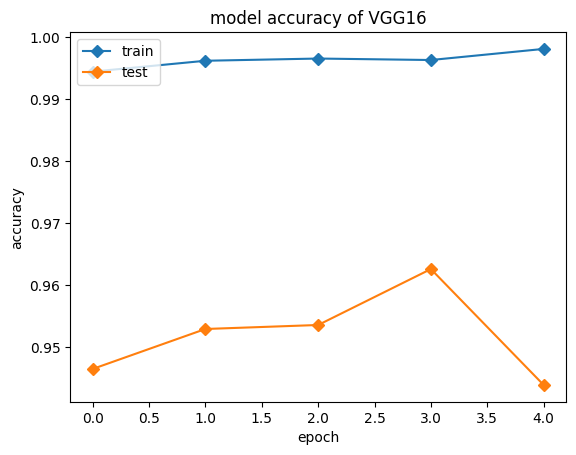

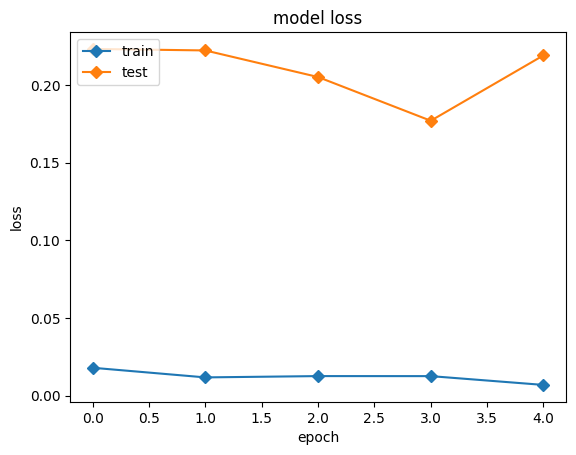

In [ ]:
plt.plot(history_fine_tune.history['accuracy'], marker='D')
plt.plot(history_fine_tune.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history_fine_tune.history['loss'], marker='D')
plt.plot(history_fine_tune.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from art.estimators.classification import TensorFlowV2Classifier
model_attack = tf.keras.models.load_model('/content/drive/MyDrive/ResNet50.h5')
tf.compat.v1.enable_eager_execution()
print("Eager Execution:", tf.executing_eagerly())
IMG_SIZE = (224, 224)
test_dir = os.path.join(output_dir, 'test')

# Создаем генератор тестовых данных
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=50,  # Загрузим все данные для атаки
    class_mode='categorical',
    shuffle=False
)

# Извлекаем данные и метки
x_test, y_test = next(test_generator)
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

def predict_fn(x, training=False):
    return model_attack(x, training=False)

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)  # Функция потерь

classifier = TensorFlowV2Classifier(
    model=predict_fn,
    nb_classes=43,  # Количество классов GTSRB
    input_shape=(224, 224, 3),
    clip_values=(0, 1),
    loss_object=loss_object  # Передача функции потерь
)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

results = []
for eps in eps_range:
    print(f"Выполняется атака FGSM с eps={eps:.6f}...")

    # Создание FGSM атаки с текущим eps
    attack = FastGradientMethod(estimator=classifier, eps=eps)

    # Генерация атакованных данных
    x_test_adv = attack.generate(x=x_test)

    # Оценка модели на атакованных данных
    predictions = classifier.predict(x_test_adv, batch_size=50)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print(f"Точность на атакованных данных (eps={eps:.6f}): {accuracy * 100:.2f}%")

    # Сохраняем результаты
    results.append({'eps': eps, 'accuracy': accuracy})

print("\nРезультаты атак:")
for result in results:
    print(f"eps={result['eps']:.6f}, accuracy={result['accuracy'] * 100:.2f}%")

Eager Execution: True
Found 7842 images belonging to 43 classes.
x_test shape: (50, 224, 224, 3)
y_test shape: (50, 43)
Выполняется атака FGSM с eps=0.003922...
Точность на атакованных данных (eps=0.003922): 62.00%
Выполняется атака FGSM с eps=0.007843...
Точность на атакованных данных (eps=0.007843): 66.00%
Выполняется атака FGSM с eps=0.011765...
Точность на атакованных данных (eps=0.011765): 64.00%
Выполняется атака FGSM с eps=0.015686...
Точность на атакованных данных (eps=0.015686): 62.00%
Выполняется атака FGSM с eps=0.019608...
Точность на атакованных данных (eps=0.019608): 62.00%
Выполняется атака FGSM с eps=0.031373...
Точность на атакованных данных (eps=0.031373): 52.00%
Выполняется атака FGSM с eps=0.039216...
Точность на атакованных данных (eps=0.039216): 44.00%
Выполняется атака FGSM с eps=0.078431...
Точность на атакованных данных (eps=0.078431): 0.00%
Выполняется атака FGSM с eps=0.196078...
Точность на атакованных данных (eps=0.196078): 0.00%
Выполняется атака FGSM с ep

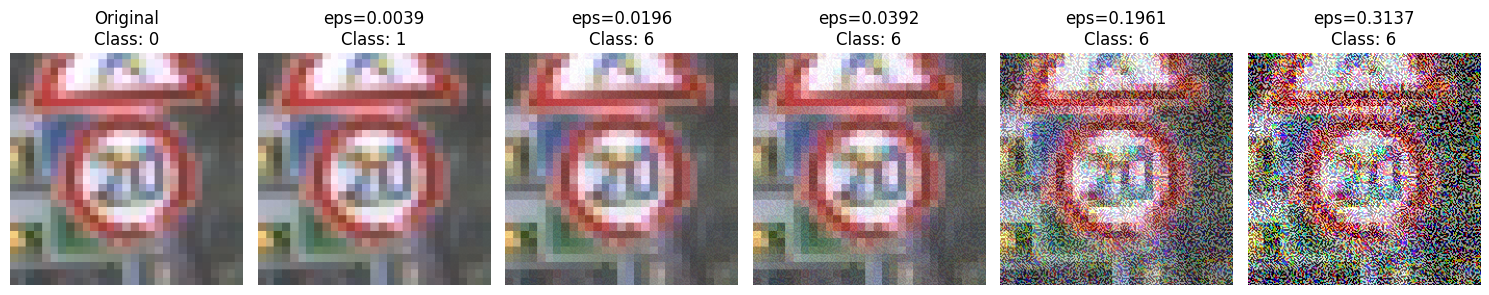

In [ ]:
eps_values = [1/255, 5/255, 10/255, 50/255, 80/255]
sample_index = 0  # Индекс изображения для демонстрации
original_image = x_test[sample_index]
original_label = np.argmax(y_test[sample_index])
# 3. Генерация атакованных изображений
attacked_images = []
predicted_classes = []

for eps in eps_values:
    # Создание FGSM атаки
    attack = FastGradientMethod(estimator=classifier, eps=eps)

    # Генерация атакованного изображения
    attacked_image = attack.generate(x=original_image.reshape(1, *original_image.shape))[0]
    attacked_images.append(attacked_image)

    # Предсказание класса
    prediction = classifier.predict(attacked_image.reshape(1, *attacked_image.shape))
    predicted_class = np.argmax(prediction)
    predicted_classes.append(predicted_class)

# 4. Визуализация
plt.figure(figsize=(15, 10))

# Отображение исходного изображения
plt.subplot(1, len(eps_values) + 1, 1)
plt.imshow(original_image)
plt.title(f"Original\nClass: {original_label}")
plt.axis("off")

# Отображение атакованных изображений
for i, eps in enumerate(eps_values):
    plt.subplot(1, len(eps_values) + 1, i + 2)
    plt.imshow(attacked_images[i])
    plt.title(f"eps={eps:.4f}\nClass: {predicted_classes[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Выполняется PGD атака с eps=0.003922...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.003922): 18.00%
Выполняется PGD атака с eps=0.007843...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.007843): 2.00%
Выполняется PGD атака с eps=0.011765...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.011765): 2.00%
Выполняется PGD атака с eps=0.015686...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.015686): 2.00%
Выполняется PGD атака с eps=0.019608...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.019608): 0.00%
Выполняется PGD атака с eps=0.031373...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.031373): 0.00%
Выполняется PGD атака с eps=0.039216...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.039216): 2.00%
Выполняется PGD атака с eps=0.078431...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.078431): 0.00%
Выполняется PGD атака с eps=0.196078...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.196078): 0.00%
Выполняется PGD атака с eps=0.313725...


PGD - Batches: 0it [00:00, ?it/s]

Точность на атакованных данных (eps=0.313725): 0.00%


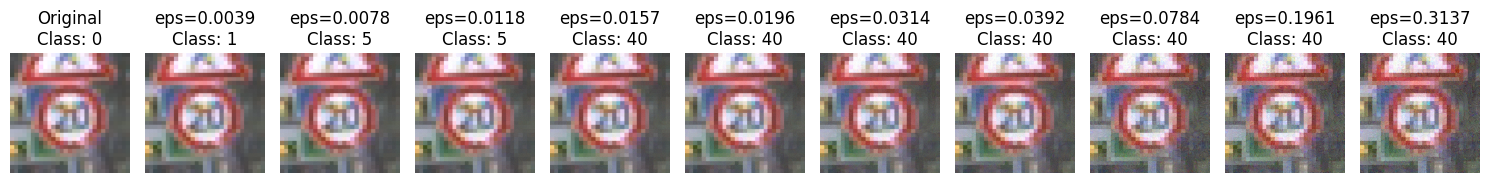


Результаты атак:
eps=0.003922, accuracy=18.00%
eps=0.007843, accuracy=2.00%
eps=0.011765, accuracy=2.00%
eps=0.015686, accuracy=2.00%
eps=0.019608, accuracy=0.00%
eps=0.031373, accuracy=0.00%
eps=0.039216, accuracy=2.00%
eps=0.078431, accuracy=0.00%
eps=0.196078, accuracy=0.00%
eps=0.313725, accuracy=0.00%


In [ ]:
eps_values = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
eps_step = 2 / 255  # Шаг изменения за итерацию
max_iter = 40  # Количество итераций

# Выполнение PGD атак для каждого eps
results2 = []
attacked_images_per_eps2 = {}

for eps in eps_values:
    print(f"Выполняется PGD атака с eps={eps:.6f}...")

    # Создание PGD атаки
    attack = ProjectedGradientDescent(
        estimator=classifier,
        norm=np.inf,
        eps=eps,
        eps_step=eps_step,
        max_iter=max_iter,
        targeted=False
    )

    # Генерация атакованных данных
    x_test_adv = attack.generate(x=x_test)
    attacked_images_per_eps2[eps] = x_test_adv  # Сохраняем атакованные изображения

    # Оценка модели на атакованных данных
    predictions = classifier.predict(x_test_adv, batch_size=50)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print(f"Точность на атакованных данных (eps={eps:.6f}): {accuracy * 100:.2f}%")

    # Сохраняем результаты
    results2.append({'eps': eps, 'accuracy': accuracy})

# Визуализация для отдельных eps
sample_index = 0  # Индекс изображения для демонстрации
original_image = x_test[sample_index]

plt.figure(figsize=(15, 10))

# Исходное изображение
plt.subplot(1, len(eps_values) + 1, 1)
plt.imshow(original_image)
plt.title(f"Original\nClass: {np.argmax(y_test[sample_index])}")
plt.axis("off")

# Атакованные изображения
for i, eps in enumerate(eps_values):
    attacked_image = attacked_images_per_eps2[eps][sample_index]
    attacked_prediction = np.argmax(classifier.predict(attacked_image.reshape(1, *attacked_image.shape)))

    plt.subplot(1, len(eps_values) + 1, i + 2)
    plt.imshow(attacked_image)
    plt.title(f"eps={eps:.4f}\nClass: {attacked_prediction}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Вывод результатов
print("\nРезультаты атак:")
for result in results2:
    print(f"eps={result['eps']:.6f}, accuracy={result['accuracy'] * 100:.2f}%")

Evaluating FGSM with eps=0.003922...
FGSM Accuracy at eps=0.003922: 62.00%
Evaluating FGSM with eps=0.019608...
FGSM Accuracy at eps=0.019608: 62.00%
Evaluating FGSM with eps=0.039216...
FGSM Accuracy at eps=0.039216: 44.00%
Evaluating FGSM with eps=0.196078...
FGSM Accuracy at eps=0.196078: 0.00%
Evaluating FGSM with eps=0.313725...
FGSM Accuracy at eps=0.313725: 0.00%
Evaluating PGD with eps=0.003922...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.003922: 20.00%
Evaluating PGD with eps=0.019608...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.019608: 0.00%
Evaluating PGD with eps=0.039216...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.039216: 2.00%
Evaluating PGD with eps=0.196078...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.196078: 0.00%
Evaluating PGD with eps=0.313725...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.313725: 0.00%


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 120598 (\N{MATHEMATICAL ITALIC EPSILON SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


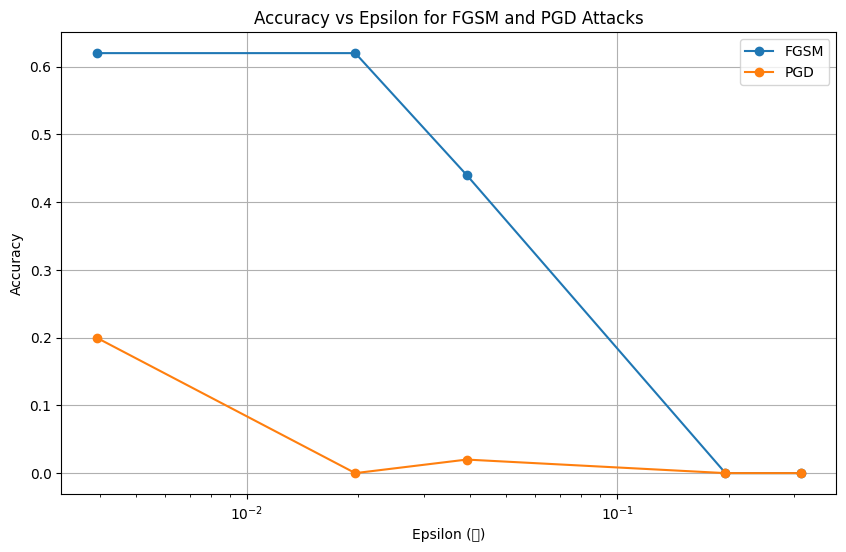

In [ ]:
eps_values = [1/255, 5/255, 10/255, 50/255, 80/255]
accuracy_results = {"FGSM": [], "PGD": []}

# Функция для выполнения атаки и оценки точности
def evaluate_attack(attack_name, attack_object, x_test, y_test):
    accuracies = []
    for eps in eps_values:
        print(f"Evaluating {attack_name} with eps={eps:.6f}...")

        # Обновляем параметр eps для атаки
        attack_object.set_params(eps=eps)

        # Генерация атакованных данных
        x_test_adv = attack_object.generate(x=x_test)

        # Оценка точности
        predictions = classifier.predict(x_test_adv, batch_size=16)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        print(f"{attack_name} Accuracy at eps={eps:.6f}: {accuracy * 100:.2f}%")
        accuracies.append(accuracy)
    return accuracies
fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.0)  # eps будет изменяться в цикле
pgd_attack = ProjectedGradientDescent(
    estimator=classifier,
    norm=np.inf,
    eps=0.0,  # eps будет изменяться в цикле
    eps_step=2/255,
    max_iter=40,
    targeted=False
)
# Оценка модели для FGSM
accuracy_results["FGSM"] = evaluate_attack("FGSM", fgsm_attack, x_test, y_test)

# Оценка модели для PGD
accuracy_results["PGD"] = evaluate_attack("PGD", pgd_attack, x_test, y_test)

# Построение графика
plt.figure(figsize=(10, 6))

plt.plot(eps_values, accuracy_results["FGSM"], marker='o', label='FGSM')
plt.plot(eps_values, accuracy_results["PGD"], marker='o', label='PGD')

# Настройки графика
plt.title('Accuracy vs Epsilon for FGSM and PGD Attacks')
plt.xlabel('Epsilon (𝜖)')
plt.ylabel('Accuracy')
plt.xscale('log')  # Логарифмическая шкала для eps
plt.grid(True)
plt.legend()

# Отображение графика
plt.show()

Found 7842 images belonging to 43 classes.
Evaluating FGSM with eps=0.003922...
FGSM Accuracy at eps=0.003922: 27.50%
Evaluating FGSM with eps=0.019608...
FGSM Accuracy at eps=0.019608: 27.50%
Evaluating FGSM with eps=0.039216...
FGSM Accuracy at eps=0.039216: 52.50%
Evaluating FGSM with eps=0.196078...
FGSM Accuracy at eps=0.196078: 0.00%
Evaluating FGSM with eps=0.313725...
FGSM Accuracy at eps=0.313725: 0.00%
Evaluating PGD with eps=0.003922...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.003922: 5.00%
Evaluating PGD with eps=0.019608...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.019608: 0.00%
Evaluating PGD with eps=0.039216...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.039216: 0.00%
Evaluating PGD with eps=0.196078...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.196078: 0.00%
Evaluating PGD with eps=0.313725...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.313725: 0.00%


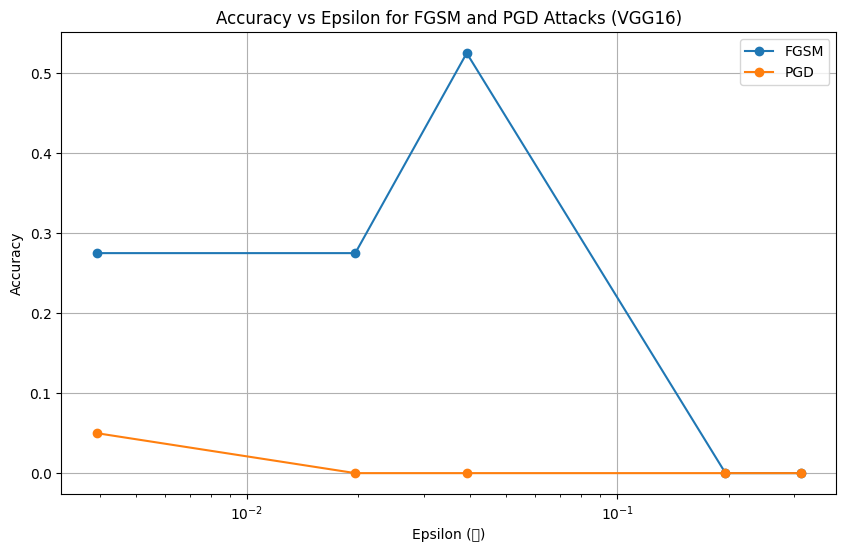

In [ ]:
eps_values = [1/255, 5/255, 10/255, 50/255, 80/255]
accuracy_results_vgg16 = {"FGSM": [], "PGD": []}

# Функция для выполнения атаки и оценки точности
def evaluate_attack(attack_name, attack_object, x_test, y_test):
    accuracies = []
    for eps in eps_values:
        print(f"Evaluating {attack_name} with eps={eps:.6f}...")

        # Обновляем параметр eps для атаки
        attack_object.set_params(eps=eps)

        # Генерация атакованных данных
        x_test_adv = attack_object.generate(x=x_test)

        # Оценка точности
        predictions = classifier_vgg16.predict(x_test_adv, batch_size=16)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        print(f"{attack_name} Accuracy at eps={eps:.6f}: {accuracy * 100:.2f}%")
        accuracies.append(accuracy)
    return accuracies
model_vgg16 = tf.keras.models.load_model('/content/drive/MyDrive/vgg16.h5')

def predict_fn_vgg16(x, training=False):
    return model_vgg16(x, training=training)

loss_object_vgg16 = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
classifier_vgg16 = TensorFlowV2Classifier(
    model=predict_fn_vgg16,
    nb_classes=43,
    input_shape=(224, 224, 3),
    clip_values=(0, 1),
    loss_object=loss_object_vgg16
)

# Подготовка тестовых данных
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

test_dir = os.path.join(output_dir, 'test')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=40,
    class_mode='categorical',
    shuffle=False
)

x_test, y_test = next(test_generator)

# Создание атак
fgsm_attack_vgg16 = FastGradientMethod(estimator=classifier_vgg16, eps=0.0)  # eps будет изменяться в цикле
pgd_attack_vgg16 = ProjectedGradientDescent(
    estimator=classifier_vgg16,
    norm=np.inf,
    eps=0.0,  # eps будет изменяться в цикле
    eps_step=2/255,
    max_iter=40,
    targeted=False
)

# Оценка модели VGG16 для FGSM
accuracy_results_vgg16["FGSM"] = evaluate_attack("FGSM", fgsm_attack_vgg16, x_test, y_test)

# Оценка модели VGG16 для PGD
accuracy_results_vgg16["PGD"] = evaluate_attack("PGD", pgd_attack_vgg16, x_test, y_test)

# Построение графика
plt.figure(figsize=(10, 6))

plt.plot(eps_values, accuracy_results_vgg16["FGSM"], marker='o', label='FGSM')
plt.plot(eps_values, accuracy_results_vgg16["PGD"], marker='o', label='PGD')

# Настройки графика
plt.title('Accuracy vs Epsilon for FGSM and PGD Attacks (VGG16)')
plt.xlabel('Epsilon (𝜖)')
plt.ylabel('Accuracy')
plt.xscale('log')  # Логарифмическая шкала для eps
plt.grid(True)
plt.legend()

# Отображение графика
plt.show()

In [ ]:
import pandas as pd

# 1. Данные точности (примерные результаты или реальные значения)
eps_values = [1/255, 5/255, 10/255, 50/255, 80/255]

# Результаты точности для FGSM и PGD для обеих моделей
accuracy_vgg16_fgsm = accuracy_results_vgg16["FGSM"]
accuracy_vgg16_pgd = accuracy_results_vgg16["PGD"]

accuracy_resnet50_fgsm = accuracy_results["FGSM"]
accuracy_resnet50_pgd = accuracy_results["PGD"]

# 2. Создание DataFrame
data = {
    "Epsilon (𝜖)": eps_values,
    "VGG16 FGSM": accuracy_vgg16_fgsm,
    "VGG16 PGD": accuracy_vgg16_pgd,
    "ResNet50 FGSM": accuracy_resnet50_fgsm,
    "ResNet50 PGD": accuracy_resnet50_pgd
}

df = pd.DataFrame(data)

# 3. Вывод таблицы
print("Таблица точности:")
print(df)


Таблица точности:
   Epsilon (𝜖)  VGG16 FGSM  VGG16 PGD  ResNet50 FGSM  ResNet50 PGD
0     0.003922       0.275       0.05           0.62          0.20
1     0.019608       0.275       0.00           0.62          0.00
2     0.039216       0.525       0.00           0.44          0.02
3     0.196078       0.000       0.00           0.00          0.00
4     0.313725       0.000       0.00           0.00          0.00
